In [1]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
Setup complete  (16 CPUs, 15.2 GB RAM, 818.4/930.6 GB disk)


Install required packages

Import required packages

In [2]:
from ultralytics import YOLO
import pandas as pd
from IPython.display import display, Image
import shutil

import os
import re
import json
from pylabel import importer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
pd.set_option('display.max_columns', None)


# 2. Inspect the Dataset

This is a instance-segmented underwater trash dataset, containing thousands of images with different types of trash, plants, and animals.

There are two versions of this dataset: the **material version** (with classes defined by the material of the trash), the **instance version** (with classes defined by the type of object of the trash). The data for both these versions is in the dataset.zip file, along with the original data, and scripts for creating these two dataset versions. The instance_checkpoints.zip and material_checkponts.zip files contain checkpoints for Faster-RCNN and Mask-RCNN evaluations of both the instance and material checkpoints (respectively).

In this project, I am interested in segmenting trash based on its material. Therefore, we will only focus on the material version of the dataset.

Define path.

In [11]:
train_path = "../../data/material_version/train"
valid_path = "../../data/material_version/val"

train_annots = "../../data/material_version/instances_train_trashcan.json"
valid_annots = "../../data/material_version/instances_val_trashcan.json"

destination_path = "../../destination"

results = "reports/results"

# 3. Data Preprocessing

In [4]:
class ScriptUtilities:
    @staticmethod
    def json_viewer(annots_json):
        # Read the JSON file
        with open(annots_json, 'r') as file:
            annotations_data = json.load(file)

        # Display information for the top 5 images
        for image_info in annotations_data['images'][:5]:
            print(f"Image ID: {image_info['id']}")
            print(f"File Name: {image_info['file_name']}")
            print(f"Height: {image_info['height']}, Width: {image_info['width']}")
            print(f"Date Captured: {image_info['date_captured']}")
            print("----------------------")

        # View content under 'annotations' key
        if 'annotations' in annotations_data:
            print("Annotations:")
            for annotation in annotations_data['annotations'][:5]:
                print(annotation)
                print("----------------------")
        else:
            print("No 'annotations' key found in the JSON data.")

    @staticmethod
    def json_tree(annots_json):
        # Read the JSON file
        with open(annots_json, 'r') as file:
            annotations_data = json.load(file)
        # Print the keys at the top level of the JSON structure
        print(annotations_data.keys())

    @staticmethod
    def coco_to_yolo_converter(annots_json, path_to_images, name):
        dataset = importer.ImportCoco(annots_json, path_to_images=path_to_images, name=name)

        return dataset

## Convert COCO to YOLO format

The original dataset is in COCO format. As we want to train on YOLO-based detection model, we must convert from COCO annotation format to YOLO.

In [5]:
# Train dataset
train_dataset = ScriptUtilities.coco_to_yolo_converter(train_annots, train_path, name="BCCD_train_coco")

# Valid dataset
valid_dataset = ScriptUtilities.coco_to_yolo_converter(valid_annots, valid_path, name="BCCD_valid_coco")

Sanity check.

In [6]:
train_dataset.df.sample(5)


,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,ann_bbox_xmax,ann_bbox_ymax,ann_bbox_width,ann_bbox_height,ann_area,ann_segmentation,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2263,../../data/material_version/train,vid_000105_frame0000005.jpg,,1384,480,360,,,168.005952,167.004630,201.994048,197.995763,33.988095,30.991133,726.464295,"[[183.0, 197.99576271186442, 187.0, 195.991379...",0,,,,,12,trash_metal,trash_metal,,1
6218,../../data/material_version/train,vid_000085_frame0000040.jpg,,3808,480,270,,,215.001961,2.001961,471.998039,49.998039,256.996078,47.996078,6847.467655,"[[456.0, 49.998039215686276, 468.0, 47.9980392...",0,,,,,7,animal_eel,animal_eel,,1
8376,../../data/material_version/train,vid_000070_frame0000011.jpg,,5167,480,270,,,201.004202,180.009804,226.988095,270.997696,25.983894,90.987892,1642.777243,"[[216.0, 270.99769585253455, 218.9933333333333...",0,,,,,16,trash_wood,trash_wood,,1
3071,../../data/material_version/train,vid_000532_frame0000156.jpg,,1921,480,270,,,114.002392,194.031250,144.997934,248.997967,30.995542,54.966717,1253.033562,"[[136.0, 248.9979674796748, 142.0, 245.9888888...",0,,,,,12,trash_metal,trash_metal,,1
4191,../../data/material_version/train,vid_000040_frame0000004.jpg,,2574,480,270,,,437.006944,148.014286,480.998039,187.978261,43.991095,39.963975,1158.232912,"[[476.0, 187.97826086956522, 480.998, 185.0, 4...",0,,,,,9,trash_etc,trash_etc,,1


In [7]:
valid_dataset.df.sample(5)


,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,ann_bbox_xmax,ann_bbox_ymax,ann_bbox_width,ann_bbox_height,ann_area,ann_segmentation,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2516,../../data/material_version/val,vid_000150_frame0000025.jpg,,7172,480,360,,,0.001961,205.001961,321.998039,360.998039,321.996078,155.996078,44823.176486,"[[294.0, 360.9980392156863, 294.9980392156863,...",0,,,,,14,trash_plastic,trash_plastic,,1
2396,../../data/material_version/val,vid_000031_frame0000033.jpg,,7112,480,270,,,371.001961,242.001961,461.998039,268.998039,90.996078,26.996078,1081.184329,"[[460.0, 268.9980392156863, 461.9980392156863,...",0,,,,,1,rov,rov,,1
461,../../data/material_version/val,vid_000145_frame0000001.jpg,,6221,480,270,,,0.001961,133.001961,205.998039,270.998039,205.996078,137.996078,24533.292165,"[[205.0, 270.9980392156863, 205.99803921568628...",0,,,,,1,rov,rov,,1
819,../../data/material_version/val,vid_000031_frame0000032.jpg,,6389,480,270,,,371.001961,243.001961,461.998039,269.998039,90.996078,26.996078,1108.191192,"[[460.0, 269.9980392156863, 461.9980392156863,...",0,,,,,1,rov,rov,,1
133,../../data/material_version/val,vid_000105_frame0000012.jpg,,6077,480,360,,,196.009091,175.002451,321.997354,221.997093,125.988264,46.994642,2102.616910,"[[218.0, 210.99717514124293, 222.9957264957265...",0,,,,,2,plant,plant,,1


## Inspect dataset

In [8]:
dataset_list = [train_dataset, valid_dataset]

for dataset in dataset_list:
    print("\n")
    print(f"Number of images: {dataset.analyze.num_images}")
    print(f"Number of classes: {dataset.analyze.num_classes}")
    print(f"Classes:{dataset.analyze.classes}")
    print(f"Class counts:\n{dataset.analyze.class_counts}")
    print(f"Path to annotations:\n{dataset.path_to_annotations}")



Number of images: 6008
Number of classes: 16
Classes:['rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells', 'animal_crab', 'animal_eel', 'animal_etc', 'trash_etc', 'trash_fabric', 'trash_fishing_gear', 'trash_metal', 'trash_paper', 'trash_plastic', 'trash_rubber', 'trash_wood']
Class counts:
cat_name
rov                   2653
trash_etc             1630
trash_plastic         1490
trash_metal            901
animal_fish            611
plant                  405
animal_starfish        274
trash_wood             271
animal_eel             267
trash_fabric           247
animal_crab            247
animal_etc             180
animal_shells          171
trash_paper            154
trash_fishing_gear     127
trash_rubber           113
Name: count, dtype: int64
Path to annotations:
..\..\data\material_version


Number of images: 1204
Number of classes: 16
Classes:['rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells', 'animal_crab', 'animal_eel', 'animal_etc', 'trash_etc

## Visualize the annotation

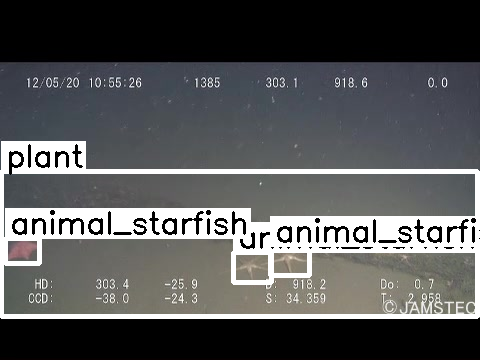

In [9]:
display(train_dataset.visualize.ShowBoundingBoxes(2))

## Export to YOLO Dataset

Export train dataset to YOLO.

In [12]:
train_dataset.export.ExportToYoloV5(output_path = f'{destination_path}/training/labels',
                              copy_images = True,
                              yaml_file = "dataset.yaml",
                              segmentation = True)

Exporting YOLO files...: 100%|██████████| 6008/6008 [00:53<00:00, 112.45it/s]


['..\\..\\destination\\training\\dataset.yaml',
 '..\\..\\destination\\training\\labels\\vid_000421_frame0000005.txt',
 '..\\..\\destination\\training\\labels\\vid_000106_frame0000015.txt',
 '..\\..\\destination\\training\\labels\\vid_000158_frame0000044.txt',
 '..\\..\\destination\\training\\labels\\vid_000044_frame0000021.txt',
 '..\\..\\destination\\training\\labels\\vid_000437_frame0000015.txt',
 '..\\..\\destination\\training\\labels\\vid_000132_frame0000098.txt',
 '..\\..\\destination\\training\\labels\\vid_000109_frame0000036.txt',
 '..\\..\\destination\\training\\labels\\vid_000285_frame0000022.txt',
 '..\\..\\destination\\training\\labels\\vid_000539_frame0000057.txt',
 '..\\..\\destination\\training\\labels\\vid_000346_frame0000020.txt',
 '..\\..\\destination\\training\\labels\\vid_000331_frame0000158.txt',
 '..\\..\\destination\\training\\labels\\vid_000332_frame0000122.txt',
 '..\\..\\destination\\training\\labels\\vid_000332_frame0000054.txt',
 '..\\..\\destination\\traini

Export valid dataset to YOLO.

In [13]:
valid_dataset.export.ExportToYoloV5(output_path = f'{destination_path}/valid/labels',
                              copy_images = True,
                              yaml_file = "dataset.yaml",
                              segmentation = True)

Exporting YOLO files...: 100%|██████████| 1204/1204 [00:11<00:00, 103.02it/s]


['..\\..\\destination\\valid\\dataset.yaml',
 '..\\..\\destination\\valid\\labels\\vid_000342_frame0000228.txt',
 '..\\..\\destination\\valid\\labels\\vid_000142_frame0000034.txt',
 '..\\..\\destination\\valid\\labels\\vid_000039_frame0000001.txt',
 '..\\..\\destination\\valid\\labels\\vid_000234_frame0000001.txt',
 '..\\..\\destination\\valid\\labels\\vid_000074_frame0000052.txt',
 '..\\..\\destination\\valid\\labels\\vid_000153_frame0000013.txt',
 '..\\..\\destination\\valid\\labels\\vid_000002_frame0000017.txt',
 '..\\..\\destination\\valid\\labels\\vid_000081_frame0000020.txt',
 '..\\..\\destination\\valid\\labels\\vid_000084_frame0000041.txt',
 '..\\..\\destination\\valid\\labels\\vid_000028_frame0000026.txt',
 '..\\..\\destination\\valid\\labels\\vid_000036_frame0000050.txt',
 '..\\..\\destination\\valid\\labels\\vid_000077_frame0000036.txt',
 '..\\..\\destination\\valid\\labels\\vid_000047_frame0000020.txt',
 '..\\..\\destination\\valid\\labels\\vid_000045_frame0000016.txt',
 '.

Sanity Check

In [ ]:
#View a sample of the segmentation annotations
!cat '../../destination/training/labels/vid_000002_frame0000022.txt'

'cat' is not recognized as an internal or external command,
operable program or batch file.


## Adjust Annotation Labels

Usually, the script that we ran above labels each categories from 1 - number of classes. So. let's say we have 10 classes, then the labelling would be 1-10 which is wrong in terms of formatting for the yolo dataset. Therefore, we need to adjust the labelling for each txt file so that it would match the requirements of the YoloV5 labels.

**Important Note:** Only run the next cell block once since the code intends to subtract 1 from the original label code to adjust the label range from {1-n_classes} to {0-n_classes-1}. This is important for the .yaml file to be understood by the model later on.

Adjust annotation labels for training dataset.

In [18]:
# Note!!! Only run this code once
path = f"../../destination/training/labels" #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")

# Code adapted from: hhttps://www.kaggle.com/code/vencerlanz09/insect-images-classification-using-yolov5

Adjust annotation labels for valid dataset.

In [19]:
# Note!!! Only run this code once
path = f"../../destination/valid/labels" #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")

# Code adapted from: hhttps://www.kaggle.com/code/vencerlanz09/insect-images-classification-using-yolov5

# 4. Model Training

In [20]:
os.environ["WANDB_MODE"]="offline"

In [ ]:
!rm -f ../destination/training/labels.cache

'rm' is not recognized as an internal or external command,
operable program or batch file.


We will train a pre-trained model weight. Download the latest model weight. Source: [Ultralytics](https://docs.ultralytics.com/tasks/segment/)

In [25]:
!wget https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-seg.pt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
import requests

url = "https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-seg.pt"
output_path = "yolov8n-seg.pt"

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(output_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded {output_path}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")


Downloaded yolov8n-seg.pt


In [27]:
# Load a model
model = YOLO(f"yolov8n-seg.pt")  # load a pretrained model (recommended for training)

In [29]:
# Train the model
results = model.train(data=f"../../destination/training/dataset.yaml", epochs=5, imgsz=(480, 270))

Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=../../destination/training/dataset.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=(480, 270), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

Exporting YOLO files...:  83%|████████▎ | 4969/6008 [15:04<03:09,  5.49it/s] 


Overriding model.yaml nc=80 with nc=16

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\labels... 6008 images, 0 backgrounds, 193 corrupt: 100%|██████████| 6008/6008 [00:11<00:00, 525.71it/s]

train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\vid_000052_frame0000054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\vid_000052_frame0000056.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\vid_000052_frame0000058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\vid_000052_frame0000060.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0021      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\v

train: New cache created: C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\labels.cache


val: Scanning C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\labels.cache... 6008 images, 0 backgrounds, 193 corrupt: 100%|██████████| 6008/6008 [00:00<?, ?it/s]

train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\vid_000052_frame0000054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\vid_000052_frame0000056.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\vid_000052_frame0000058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\vid_000052_frame0000060.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0021      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\destination\training\images\v

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 480 train, 480 val
Using 0 dataloader workers
Logging results to runs\segment\train15
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.344      2.604      3.328       1.27         25        480: 100%|██████████| 364/364 [12:44<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:53<00:00,  1.29s/it]


                   all       5815       9323      0.467      0.228      0.196       0.13      0.465      0.227      0.191      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.255      2.185      2.387      1.215         17        480: 100%|██████████| 364/364 [12:31<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:49<00:00,  1.26s/it]


                   all       5815       9323      0.554      0.375      0.354      0.228      0.554      0.376      0.351      0.206

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.215      2.112      2.126      1.199         31        480: 100%|██████████| 364/364 [12:25<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:45<00:00,  1.24s/it]


                   all       5815       9323      0.672      0.417       0.46      0.303      0.673      0.413      0.454      0.264

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.161       1.98      1.866      1.166         14        480: 100%|██████████| 364/364 [12:38<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:55<00:00,  1.29s/it]


                   all       5815       9323      0.641      0.507      0.544       0.37      0.676      0.475      0.533      0.313

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.094      1.869      1.682      1.135         22        480: 100%|██████████| 364/364 [12:52<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [04:03<00:00,  1.34s/it]


                   all       5815       9323       0.71      0.549       0.62      0.439      0.709      0.547      0.614      0.381

5 epochs completed in 1.381 hours.
Optimizer stripped from runs\segment\train15\weights\last.pt, 6.7MB
Optimizer stripped from runs\segment\train15\weights\best.pt, 6.7MB

Validating runs\segment\train15\weights\best.pt...
Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
YOLOv8n-seg summary (fused): 195 layers, 3,261,184 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:28<00:00,  1.14s/it]


                   all       5815       9323       0.71      0.549       0.62      0.439      0.709      0.547      0.614      0.381
                   rov       2136       2517      0.742      0.855      0.866      0.739      0.744      0.859      0.864      0.663
                 plant        371        392       0.77      0.668      0.706      0.412      0.764      0.663      0.699      0.326
           animal_fish        528        595      0.803      0.714      0.789      0.651      0.803      0.714      0.786      0.595
       animal_starfish         74        190      0.681     0.0789      0.182     0.0947      0.681     0.0789      0.176     0.0724
         animal_shells         99        171      0.669      0.354      0.432      0.206      0.625      0.331      0.398       0.16
           animal_crab        145        245       0.53      0.669      0.653      0.444      0.533      0.673      0.654       0.33
            animal_eel        184        266      0.708      0.455   

From the results of the training run, we can observe that most of the classes are successfully detected by the model. The majority of the classes have an mAP50 score greater than 0.8. However, there are only two classes that fall below this threshold: animal_starfish with an mAP50 score of 0.654, and trash_fishing_gear with an mAP50 score of 0.78.

# 5. Model Evaluation

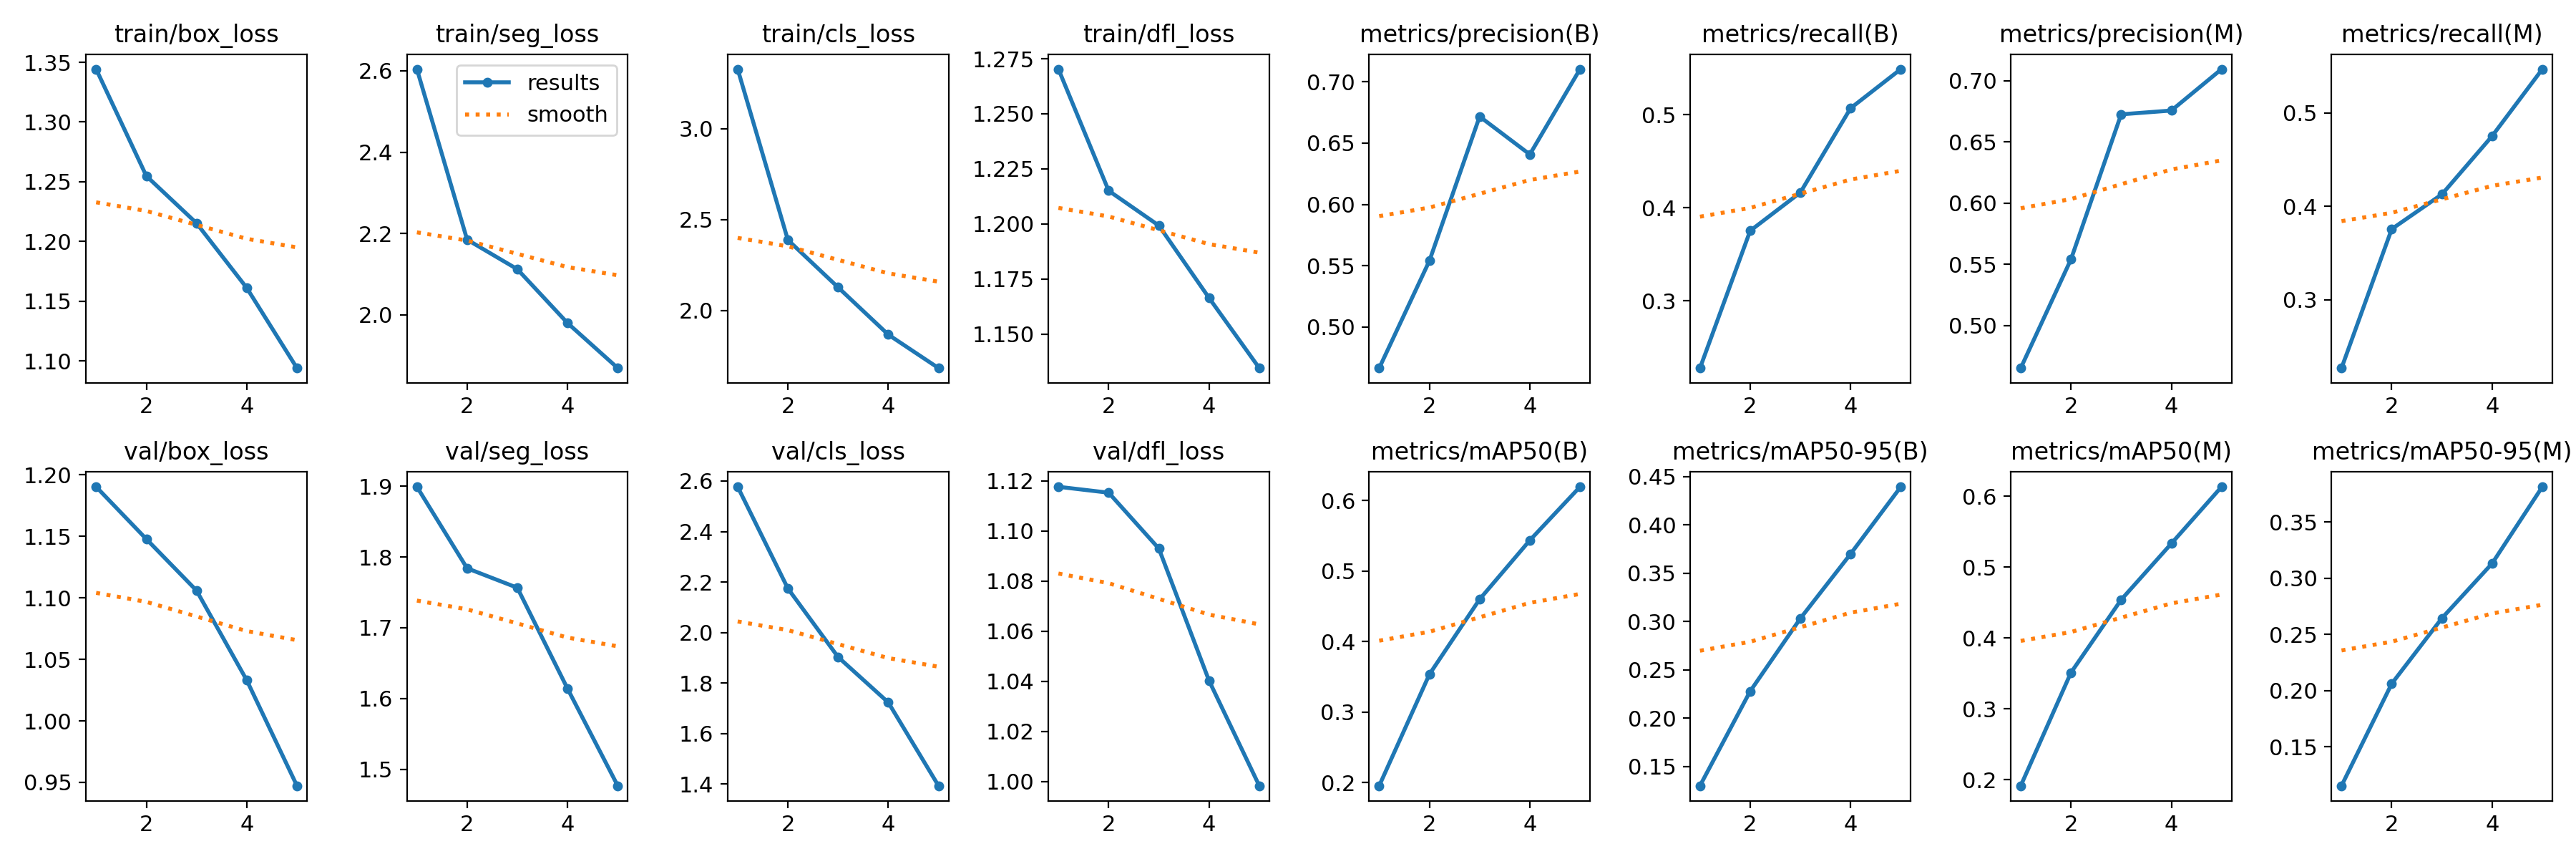

In [32]:
# Path to the PNG file
result_png_path = "../models/runs/segment/train15/results.png"

# Display the PNG file
Image(result_png_path)
